In [1]:
from ema_workbench import load_results
results = load_results('1000 scenarios 5 policies.tar.gz')

In [2]:
from __future__ import division # python2 
import math
import numpy as np
from scipy.optimize import brentq

def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    '''
    
    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1
         
    note:: w2 = 1 - w1
    
    '''
    
    rule = w1*(abs(xt-c1/r1))**3+(1-w1)*(abs(xt-c2/r2))**3
    at = min(max(rule, 0.01), 0.1)
    return at

def lake_model(b=0.42, q=2.0, mean=0.02, stdev=0.001, alpha=0.4,     
                 delta=0.98, c1=0.25, c2=0.25, r1=0.5, r2=0.5,
                 w1=0.5, nsamples=100, steps=100, seed=None):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    np.random.seed(seed)
    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    X = np.zeros((steps,))
    decisions = np.zeros((steps,))

    X[0] = 0.0

    natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size=steps)

    for t in range(steps-1):
        decisions[t] = get_antropogenic_release(X[t], c1, c2, r1, r2, w1)
        X[t+1] = (1-b)*X[t] + X[t]**q/(1+X[t]**q) + decisions[t] + natural_inflows[t]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    
    # note that I have slightly changed this formulation to retain
    # consistency with the equations in the papers
    inertia = np.sum(np.abs(np.diff(decisions)) < 0.01)/(steps-1)
    return X, utility, inertia, reliability

# Open exploration with the Exploratory Modelling Workbench

In this blog, I will continue to showcase the functionality of the exploratory modelling. In the [previous blog](https://wordpress.com/post/waterprogramming.wordpress.com/14714), I have given a general introduction to the workbench, and showed how the Direct Policy Search example that comes with Rhodium can be adapted for use with the workbench. In this blog post, I will showcase how the workbench can be used for open exploration. 

## first a short background
In exploratory modeling, we are interested in understanding how regions in the uncertainty space and/or the decision space map to the whole outcome space, or partitions thereof. There are two general approaches for investigating this mapping. The first one is through systematic sampling of the uncertainty or decision space. This is sometimes also known as open exploration. The second one is to search through the space in a directed manner using some type of optimization approach. This is sometimes also known as directed search. 

The workbench support both open exploration and directed search. Both can be applied to investigate the mapping of the uncertainty space or the decision space to the outcome space. In most applications, search is used for finding promising mappings from the decision space to the outcome space, while exploration is used to stress test these mappings under a whole range of possible resolutions to the various uncertainties. This need not be the case however. Optimization can be used to discover the worst possible scenario, while sampling can be used to get insight into the sensitivity of outcomes to the various decision levers. 

## open exploration

To showcase the open exploration functionality, let's start with a basic example using the DPS lake problem. We are going to simultaneously sample over uncertainties and decision levers. We are going to generate 1000 scenarios and 5 policies, and see how they jointly affect the outcomes. A *scenario* is understood as a point in the uncertainty space, while a *policy* is a point in the decision space. The combination of a scenario and a policy is called *experiment*. The uncertainty space is spanned by uncertainties, while the decision space is spanned by levers. Both uncertainties and levers are instances of *RealParameter* (a continuous range), *IntegerParameter* (a range of integers), or *CategoricalParameter* (an unorder set of things). By default, the workbench will use Latin Hypercube sampling for generating both the scenarios and the policies. Each policy will be always evaluated over all scenarios (i.e. a full factorial over scenarios and policies). 


In [3]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant, 
                           ReplicatorModel)

model = ReplicatorModel('lakeproblem', function=lake_model)
model.replications = 150

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2), 
                RealParameter("r2", 0, 2), 
                RealParameter("w1", 0, 1)]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                function=process_p),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                function=np.mean),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MINIMIZE,
                                function=np.mean),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                function=np.mean)]

# override some of the defaults of the model
model.constants = [Constant('alpha', 0.41),
                   Constant('steps', 100)]

```python
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=5)
```

### Visual analysis
Having generated these results, the next step is to analyze them and see what we can learn from the results. The workbench comes with a variety of techniques for this analysis. A simple first step is to make a few quick visualizations of the results. The workbench has convenience functions for this, but it also possible to create your own visualizations using the scientific Python stack. 


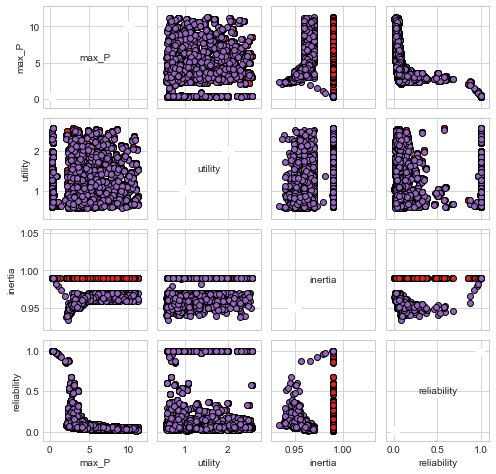

In [13]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(results, group_by='policy', 
                                         legend=False)
fig.set_size_inches(8,8)
save_fig(fig, './figs/', 'pair_scatter')
plt.show()

Writing your own visualizations requires a more in-depth understanding of how the results from the workbench are structured. `perform_experiments` returns a tuple. The first item is a numpy structured array where each row is a single experiment. The second item contains the outcomes, structured in a dict with the name of the outcome as key and a numpy array as value. Experiments and outcomes are aligned based on index. 

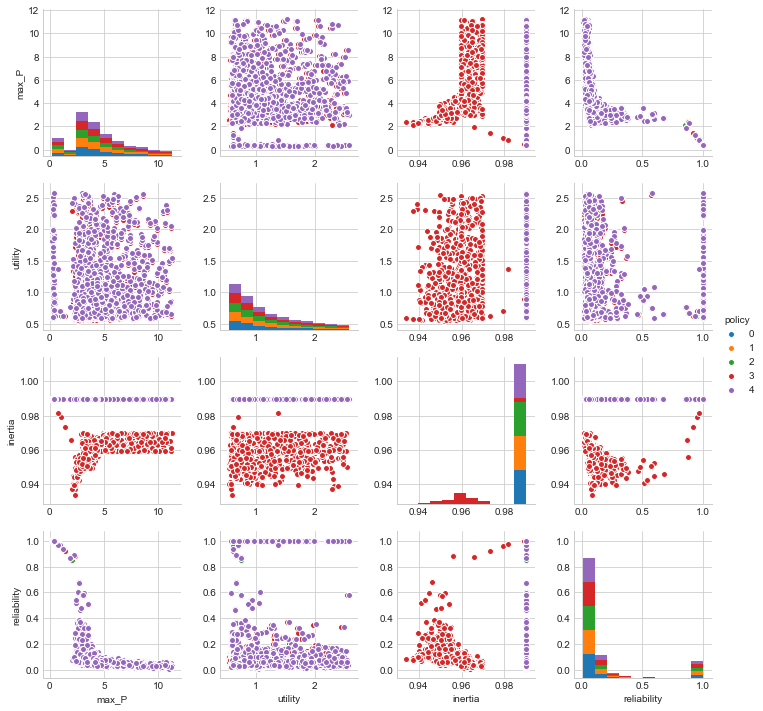

In [14]:
import seaborn as sns

experiments, outcomes = results

df = pd.DataFrame.from_dict(outcomes)
df = df.assign(policy=experiments['policy'])

# rename the policies using numbers
df['policy'] = df['policy'].map({p:i for i, p in 
                                 enumerate(set(experiments['policy']))})

grid = sns.pairplot(df, hue='policy', vars=outcomes.keys())
ax = plt.gca()

save_fig(fig, './figs/', 'pair_scatter_sns')
plt.show()


Often, it is convenient to separate the process of performing the experiments from the analysis. To make this possible, the workbench offers convenience functions for storing results to disc and loading them from disc. The workbench will store the results in a tarbal with .csv files and separate metadata files. This is a convenient format that has proven sufficient over the years. 

```python
from ema_workbench import save_results
save_results(results, '1000 scenarios 5 policies.tar.gz')

from ema_workbench import load_results
results = load_results('1000 scenarios 5 policies.tar.gz')
```

## advanced analysis
In addition to visual analysis, the workbench comes with a variety of techniques to perform a more in-depth analysis of the results. In addition, other analyses can simply be performed by utilizing the scientific python stack. The workbench comes with

* [Scenario Discovery](https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/), a model driven approach to scenario development
* Dimensional stacking, a quick visual approach drawing on feature scoring to enable scenario discovery. This approach has received limited attention in the literature [(Suzuki et al., 2015)](https://www.onepetro.org/conference-paper/SPE-174774-MS). The implementation in the workbench replaces the rule mining approach with a feature scoring approach. 
* Feature Scoring, a poor man's alternative to global sensitivity analysis
* Regional sensitivity analysis

### Scenario Discovery
A detailed discussion on scenario discovery can be found in an [earlier blogpost](https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/). For completeness, I provide a code snippet here. Compared to the previous blog post, there is one small change. The library mpld3 is currently not being maintained and broken on Python 3.5. and higher. To still utilize the interactive exploration of the trade offs within the notebook, use the interactive back-end as shown below. 

In [6]:
from ema_workbench.analysis import prim

experiments, outcomes = results

x = experiments
y = outcomes['max_P'] <0.8
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

<IPython.core.display.Javascript object>


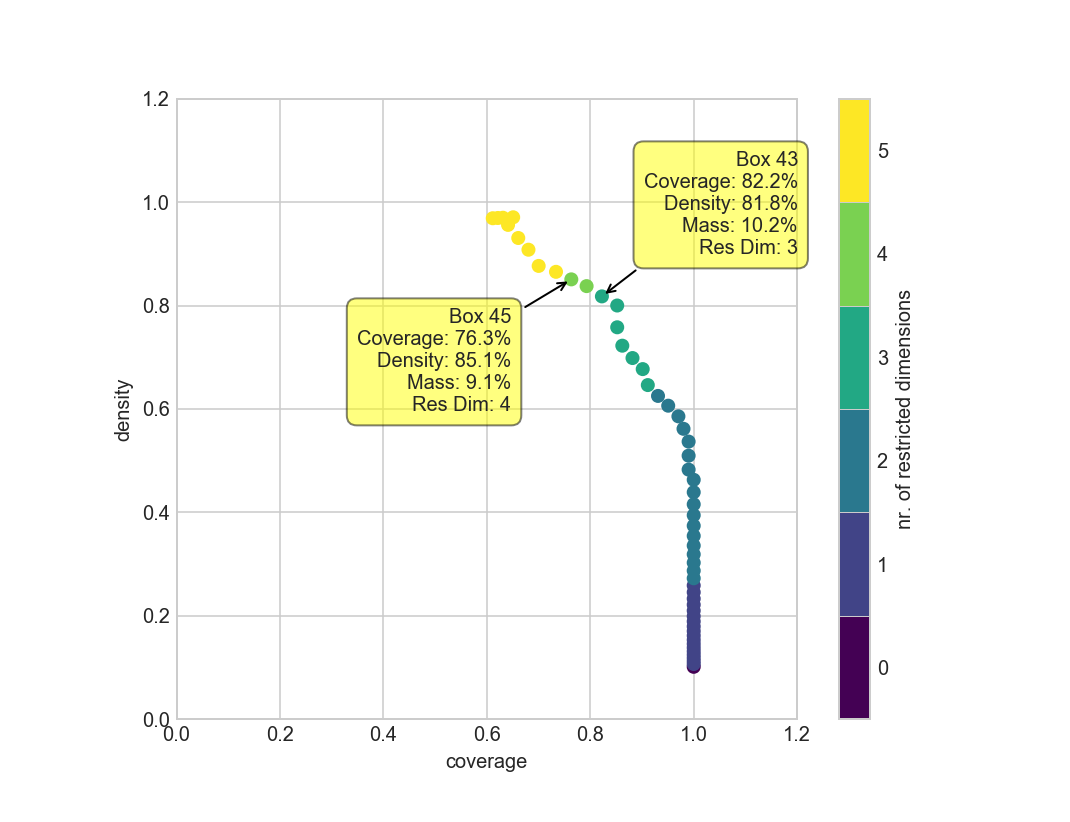

In [8]:
%matplotlib notebook
box1.show_tradeoff()
plt.show()

coverage    0.822485
density     0.817647
mass           0.102
mean        0.817647
res dim            3
Name: 43, dtype: object

        box 43                         
           min       max      qp values
b     0.354329  0.449672  2.561141e-150
q     3.278153  4.497550   1.809524e-64
mean  0.010010  0.036874   3.472366e-19



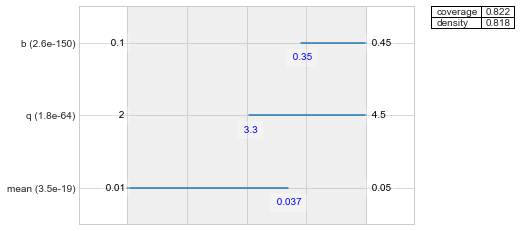

In [15]:
%matplotlib inline 
# we go back to default not interactive
box1.inspect(43)
box1.inspect(43, style='graph')
save_fig(plt.gcf(), './figs/', 'box_lims')
plt.show()

### dimensional stacking
Dimensional stacking was suggested as a more visual approach to scenario discovery. It involves two steps: identifying the most important uncertainties that affect system behavior, and creating a pivot table using the most influential uncertainties. The creating of the pivot table involves binning the uncertainties. More details can be found in [Suzuki et al. (2015)](https://www.onepetro.org/conference-paper/SPE-174774-MS) or by looking through the code in the workbench. Compared to the original paper, I use feature scoring for determining the most influential uncertainties. The code is set up in a modular way so other approaches to global sensitivity analysis can easily be used as well if so desired. 


/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


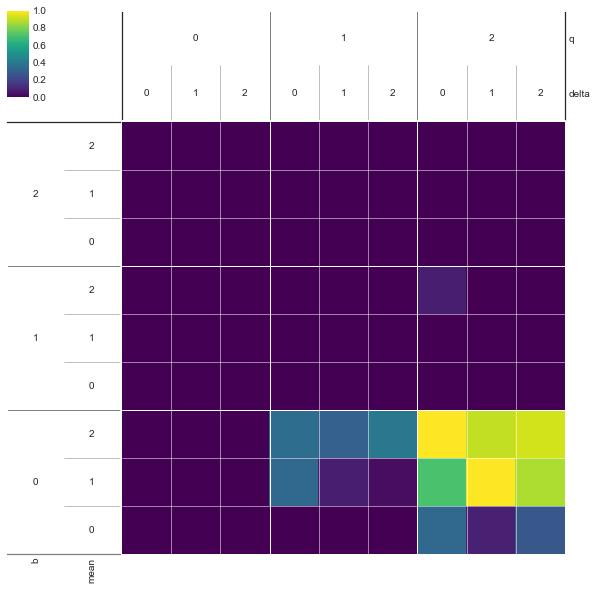

In [16]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = outcomes['max_P'] <0.8
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
save_fig(plt.gcf(), './figs/', 'dimensional_stacking')
plt.show()


We can see from this visual that if B is low, while Q is high, we have a high concentration of cases where pollution stays below 0.8. The mean and delta have some limited additional influence. By playing around with an alternative number of bins, or different number of layers, patterns can be coarsened or refined. 

### regional sensitivity analysis

A third approach for supporting scenario discovery is to perform a regional sensitivity analysis. The workbench implements a visual approach based on plotting the empirical CDF given a classification vector. Please look at section 3.4 in [Pianosi et al (2016)](http://www.sciencedirect.com/science/article/pii/S1364815216300287#sec3.4) for more details.

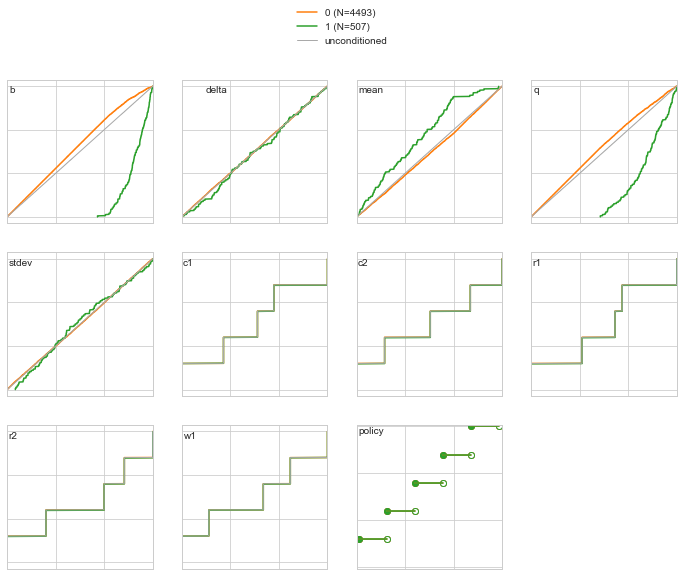

In [17]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

x = rf.drop_fields(experiments, 'model', asrecarray=True)
y = outcomes['max_P'] < 0.8
regional_sa.plot_cdfs(x,y)
save_fig(plt.gcf(), './figs/', 'regional_sa')
plt.show()

### feature scoring
Feature scoring is a family of techniques often used in machine learning to identify the most relevant features to include in a model. This is similar to one of the use cases for global sensitivity analysis, namely factor prioritisation. In some of the work ongoing in Delft, we are comparing feature scoring with Sobol and Morris and the results are quite positive. The main advantage of feature scoring techniques is that they impose virtually no constraints on the experimental design, while they can handle real valued, integer valued, and categorical valued parameters. The workbench supports multiple techniques, the most useful of which generally is extra trees [(Geurts et al. 2006)](https://link.springer.com/article/10.1007/s10994-006-6226-1). 

For this example, we run feature scoring for each outcome of interest. We can also run it for a specific outcome if desired. Similarly, we can choose if we want to run in regression mode or classification mode. The later is applicable if the outcome is a categorical variable and the results should be interpreted similar to regional sensitivity analysis results. For more details, see the documentation.

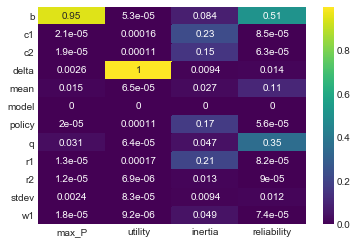

In [18]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
save_fig(plt.gcf(), './figs/', 'feature_scoring')
plt.show()

From the results, we see that max_P is primarily influenced by b, while utility is driven by delta, for inertia and reliability the situation is a little bit less clear cut. 

#### linear regression

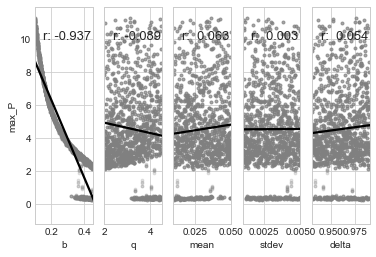

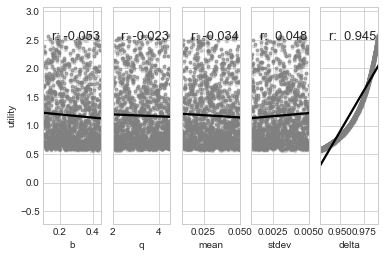

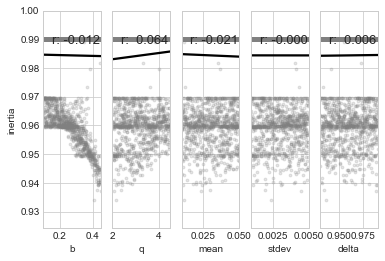

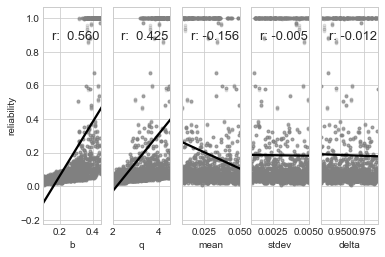

In [33]:
experiments, outcomes = results

for key, value in outcomes.items():
    params = model.uncertainties #+ model.levers[:]
    
    fig, axes = plt.subplots(ncols=len(params), sharey=True)
    y = value

    for i, param in enumerate(params):
        ax = axes[i]
        ax.set_xlabel(param.name)
        
        pearson = sp.stats.pearsonr(experiments[param.name], y)
        ax.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), 
                    xycoords='axes fraction',fontsize=13)
        
        x = experiments[param.name]
        sns.regplot(x, y, ax=ax, ci=None, color='k',
                    scatter_kws={'alpha':0.2, 's':8, 'color':'gray'})
        ax.set_xlim(param.lower_bound, param.upper_bound)
        
        
    axes[0].set_ylabel(key)    

plt.show()


## More advanced sampling techniques

The workbench can also be used for more advanced sampling techniques. To achieve this, it relies on [SALib](http://salib.readthedocs.io/en/latest/). On the workbench side, the only change is to specify the sampler we want to use. Next, we can use SALib directly to perform the analysis. To help with this, the workbench provides a convenience function for generating the problem dict which SALib provides. The example below focusses on performing SOBOL on the uncertainties, but we could do the exact same thing with the levers instead. The only changes required would be to set `lever_sampling` instead of `uncertainty_sampling`, and get the SALib problem dict based on the levers.


In [ ]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, 
                                               uncertainty_sampling='sobol')
    
experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes['max_P'], 
                   calc_second_order=True, print_to_console=False)

In [ ]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df